In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file1 = '/content/drive/MyDrive/Colab Notebooks/따릉이/train.csv'
file2 = '/content/drive/MyDrive/Colab Notebooks/따릉이/test.csv'
file3 = '/content/drive/MyDrive/Colab Notebooks/따릉이/submission.csv'

In [4]:
train = pd.read_csv(file1)
test = pd.read_csv(file2)
submission = pd.read_csv(file3)

In [5]:
train.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

# 시각화

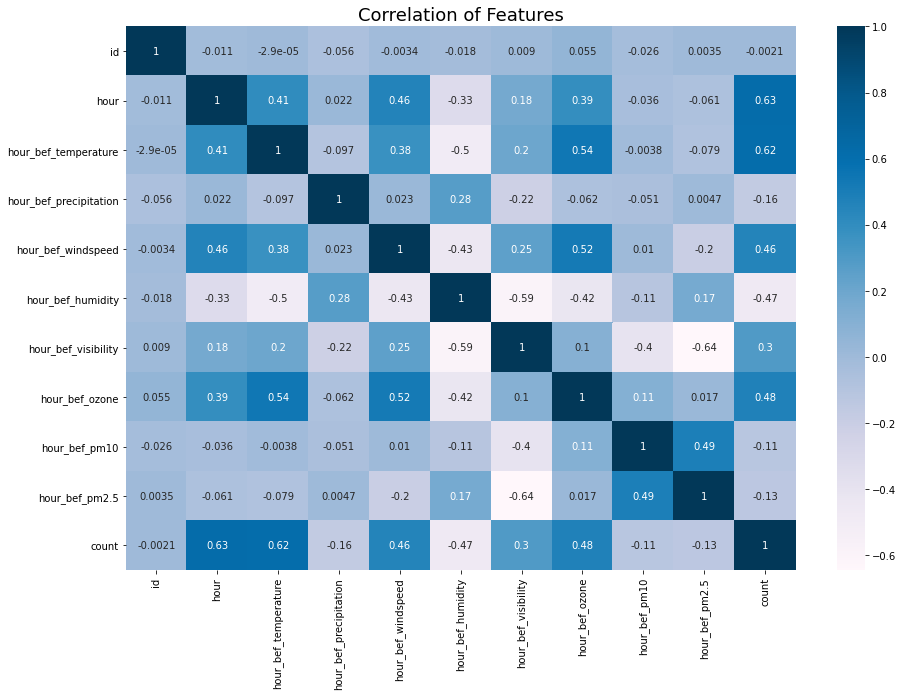

In [ ]:
plt.figure(figsize = (15,10))
plt.title('Correlation of Features',size=18)

sns.heatmap(train.corr(), cmap = plt.cm.PuBu, linecolor = 'white',annot =True)

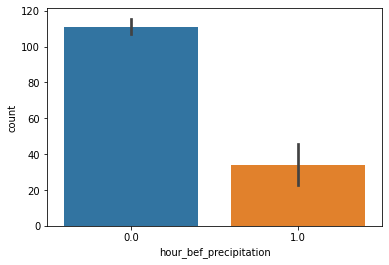

In [ ]:
sns.barplot(data = train, x = 'hour_bef_precipitation', y = 'count')

In [ ]:
train.loc[train['hour_bef_precipitation']== 1,'count'].mean(), train.loc[train['hour_bef_precipitation']== 0,'count'].mean()

(33.67391304347826, 111.13040396881644)

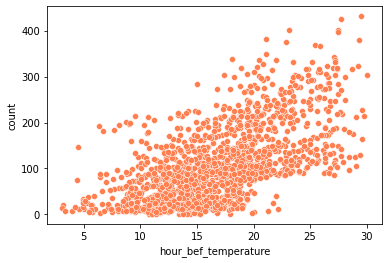

In [ ]:
sns.scatterplot(data = train, x = 'hour_bef_temperature', y = 'count',color = 'coral')

Text(0.5, 1.0, 'Count by Hours')

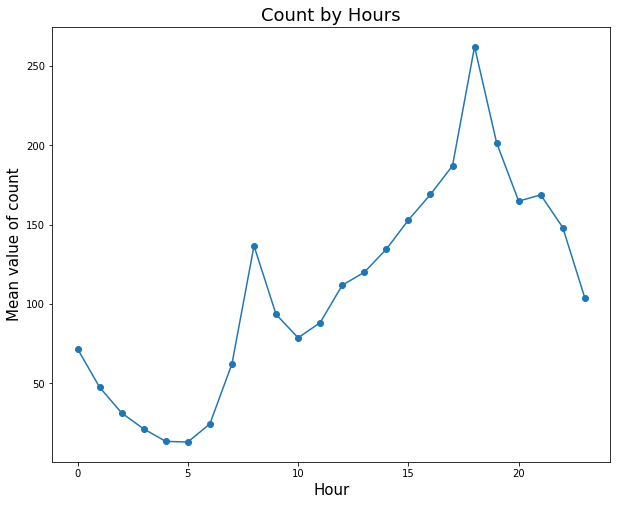

In [ ]:
group = train.groupby(['hour'])['count'].mean()
plt.figure(figsize = (10,8))
plt.plot(group,'o-')

plt.xlabel('Hour',fontsize = 15)
plt.ylabel('Mean value of count',fontsize = 15)
plt.title('Count by Hours', fontsize = 18)

# 결측치 처리


데이터 결측치 처리를 어떻게 해야할 것인가?  

In [ ]:
np.sum(pd.isnull(train))

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

(array([  4.,   4.,  10.,  24.,  30.,  77., 126., 194., 207., 781.]),
 array([4.35670883, 4.68112819, 5.00554755, 5.32996692, 5.65438628,
        5.97880564, 6.30322501, 6.62764437, 6.95206373, 7.2764831 ,
        7.60090246]),
 <a list of 10 Patch objects>)

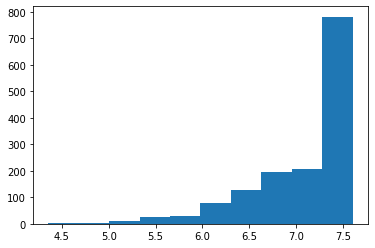

In [ ]:
plt.hist(np.log(np.array(train['hour_bef_visibility'])).reshape(-1,1))

In [ ]:
train.shape

(1459, 11)

In [ ]:
train.iloc[[934,1035], :]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [5]:
train.drop([934,1035], axis = 0, inplace =True)
train.reset_index(drop = True, inplace = True)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [7]:
test['hour_bef_temperature'].fillna(test.groupby('hour')['hour_bef_temperature'].transform('mean'), inplace=True)
test['hour_bef_precipitation'].fillna(0,inplace = True)
test['hour_bef_windspeed'].fillna(test.groupby('hour')['hour_bef_windspeed'].transform('mean'), inplace=True)
test['hour_bef_humidity'].fillna(test.groupby('hour')['hour_bef_humidity'].transform('mean'), inplace=True)
test['hour_bef_visibility'].fillna(test.groupby('hour')['hour_bef_visibility'].transform('mean'), inplace=True)

In [8]:
np.sum(pd.isnull(train)), np.sum(pd.isnull(test))

(id                          0
 hour                        0
 hour_bef_temperature        0
 hour_bef_precipitation      0
 hour_bef_windspeed          7
 hour_bef_humidity           0
 hour_bef_visibility         0
 hour_bef_ozone             74
 hour_bef_pm10              88
 hour_bef_pm2.5            115
 count                       0
 dtype: int64, id                         0
 hour                       0
 hour_bef_temperature       0
 hour_bef_precipitation     0
 hour_bef_windspeed         0
 hour_bef_humidity          0
 hour_bef_visibility        0
 hour_bef_ozone            35
 hour_bef_pm10             37
 hour_bef_pm2.5            36
 dtype: int64)

그룹을 나눠서 결측치 제거 
1. 'hour_bef_pm2.5' > hour_bef_visibility'열을 이용해 그룹핑 > 평균값으로 대체   
2. 'hour_bef_pm10' > 'hour_bef_pm2.5'열을 이용해 그룹핑 > 평균값으로 대체  
3. 'hour_bef_ozone' > 'hour_bef_temperature'열을 이용해 그룹핑 > 평균값으로 대체 
4. 'hour_bef_windspeed' > 'hour_bef_ozone' 열을 이용해 그룹핑 > 평균값으로 대체

**1. ='hour_bef_pm2.5'**

Text(0.5, 1.0, 'Distribution of null value of pm2.5 by visibility')

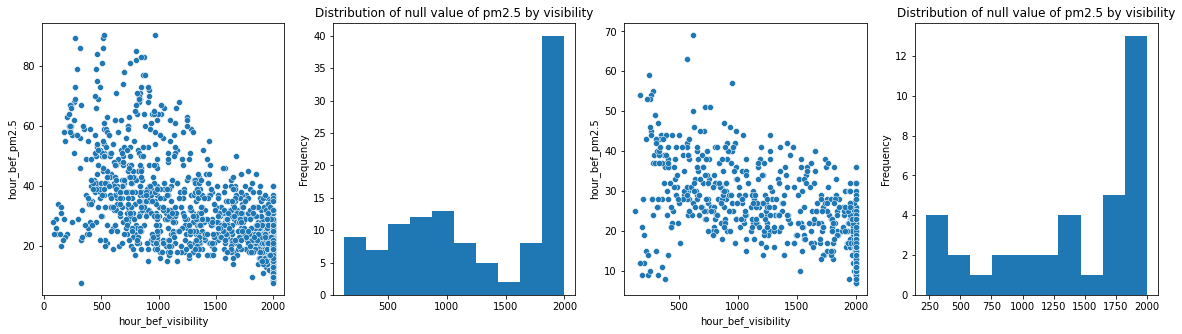

In [9]:
plt.figure(figsize=(20,5))
plt.subplot(141)
sns.scatterplot(data = train, x = 'hour_bef_visibility', y = 'hour_bef_pm2.5')
plt.subplot(142)
train.loc[train['hour_bef_pm2.5'].isnull() == True, 'hour_bef_visibility'].plot(kind = 'hist')
plt.title('Distribution of null value of pm2.5 by visibility', fontsize = 12)
plt.subplot(143)
sns.scatterplot(data = test, x = 'hour_bef_visibility', y = 'hour_bef_pm2.5')
plt.subplot(144)
test.loc[test['hour_bef_pm2.5'].isnull() == True, 'hour_bef_visibility'].plot(kind = 'hist')
plt.title('Distribution of null value of pm2.5 by visibility', fontsize = 12)

In [10]:
g1 = train.loc[(0 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 500) == True, 'hour_bef_pm2.5']
g2 = train.loc[(500 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 1000) == True, 'hour_bef_pm2.5']
g3 = train.loc[(1000 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 1500) == True, 'hour_bef_pm2.5']
g4 = train.loc[(1500 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 2000) == True, 'hour_bef_pm2.5']

gt1 = test.loc[(0 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 500) == True, 'hour_bef_pm2.5']
gt2 = test.loc[(500 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 1000) == True, 'hour_bef_pm2.5']
gt3 = test.loc[(1000 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 1500) == True, 'hour_bef_pm2.5']
gt4 = test.loc[(1500 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 2000) == True, 'hour_bef_pm2.5']

In [11]:
g1.mean(), g2.mean(), g3.mean(), g4.mean()

(45.94059405940594, 42.31229235880399, 32.22608695652174, 22.409859154929578)

In [12]:
gt1.mean(), gt2.mean(), gt3.mean(), gt4.mean()

(32.76190476190476, 32.04054054054054, 26.818181818181817, 19.258160237388726)

In [13]:
c1 = (train['hour_bef_pm2.5'].isnull() == True) & ((0 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 500) == True)
c2 = (train['hour_bef_pm2.5'].isnull() == True) & ((500 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 1000) == True)
c3 = (train['hour_bef_pm2.5'].isnull() == True) & ((1000 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 1500)== True)
c4 = (train['hour_bef_pm2.5'].isnull() == True) & ((1500 < train['hour_bef_visibility']) & (train['hour_bef_visibility'] <= 2000) == True)

ct1 = (test['hour_bef_pm2.5'].isnull() == True) & ((0 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 500) == True)
ct2 = (test['hour_bef_pm2.5'].isnull() == True) & ((500 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 1000) == True)
ct3 = (test['hour_bef_pm2.5'].isnull() == True) & ((1000 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 1500)== True)
ct4 = (test['hour_bef_pm2.5'].isnull() == True) & ((1500 < test['hour_bef_visibility']) & (test['hour_bef_visibility'] <= 2000) == True)

In [14]:
train.loc[c1, 'hour_bef_pm2.5'] = g1.mean()
train.loc[c2, 'hour_bef_pm2.5'] = g2.mean()
train.loc[c3, 'hour_bef_pm2.5'] = g3.mean()
train.loc[c4, 'hour_bef_pm2.5'] = g4.mean()

test.loc[ct1, 'hour_bef_pm2.5'] = gt1.mean()
test.loc[ct2, 'hour_bef_pm2.5'] = gt2.mean()
test.loc[ct3, 'hour_bef_pm2.5'] = gt3.mean()
test.loc[ct4, 'hour_bef_pm2.5'] = gt4.mean()

**2 . 'hour_bef_pm10'**

Text(0.5, 1.0, 'Distribution of null value of pm10 by pm2.5')

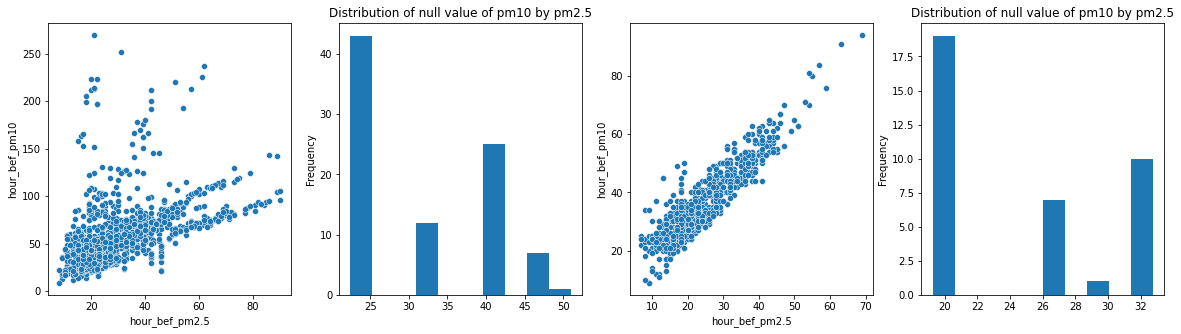

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(141)
sns.scatterplot(data = train, x = 'hour_bef_pm2.5', y = 'hour_bef_pm10')
plt.subplot(142)
train.loc[train['hour_bef_pm10'].isnull() == True, 'hour_bef_pm2.5'].plot(kind = 'hist')
plt.title('Distribution of null value of pm10 by pm2.5', fontsize = 12)
plt.subplot(143)
sns.scatterplot(data = test, x = 'hour_bef_pm2.5', y = 'hour_bef_pm10')
plt.subplot(144)
test.loc[test['hour_bef_pm10'].isnull() == True, 'hour_bef_pm2.5'].plot(kind = 'hist')
plt.title('Distribution of null value of pm10 by pm2.5', fontsize = 12)

In [16]:
gg1 = train.loc[(10 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 20) == True, 'hour_bef_pm10']
gg2 = train.loc[(20 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 30) == True, 'hour_bef_pm10']
gg3 = train.loc[(30 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 40) == True, 'hour_bef_pm10']
gg4 = train.loc[(40 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 50) == True, 'hour_bef_pm10']
gg5 = train.loc[(50 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 60) == True, 'hour_bef_pm10']

ggt1 = test.loc[(10 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 20) == True, 'hour_bef_pm10']
ggt2 = test.loc[(20 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 30) == True ,'hour_bef_pm10']
ggt3 = test.loc[(30 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 40) == True, 'hour_bef_pm10']

In [17]:
gg1.mean(), gg2.mean(), gg3.mean(), gg4.mean(), gg5.mean()

(43.207602339181285,
 49.74791666666667,
 66.34831460674157,
 73.1,
 83.7605633802817)

In [18]:
ggt1.mean(), ggt2.mean(), ggt3.mean()

(26.91891891891892, 36.431451612903224, 48.943548387096776)

In [19]:
cc1 = (train['hour_bef_pm10'].isnull() == True) & ((10 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 20) == True)
cc2 = (train['hour_bef_pm10'].isnull() == True) & ((20 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 30) == True)
cc3 = (train['hour_bef_pm10'].isnull() == True) & ((30 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 40) == True)
cc4 = (train['hour_bef_pm10'].isnull() == True) & ((40 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 50) == True)
cc5 = (train['hour_bef_pm10'].isnull() == True) & ((50 < train['hour_bef_pm2.5']) & (train['hour_bef_pm2.5'] <= 60) == True)

cct1 = (test['hour_bef_pm10'].isnull() == True) & ((10 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 20) == True)
cct2 = (test['hour_bef_pm10'].isnull() == True) & ((20 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 30) == True)
cct3 = (test['hour_bef_pm10'].isnull() == True) & ((30 < test['hour_bef_pm2.5']) & (test['hour_bef_pm2.5'] <= 40) == True)

In [20]:
train.loc[cc1, 'hour_bef_pm10'] = gg1.mean()
train.loc[cc2, 'hour_bef_pm10'] = gg2.mean()
train.loc[cc3, 'hour_bef_pm10'] = gg3.mean()
train.loc[cc4, 'hour_bef_pm10'] = gg4.mean()
train.loc[cc5, 'hour_bef_pm10'] = gg5.mean()

test.loc[cct1, 'hour_bef_pm10'] = ggt1.mean()
test.loc[cct2, 'hour_bef_pm10'] = ggt2.mean()
test.loc[cct3, 'hour_bef_pm10'] = ggt3.mean()

**3. 'hour_bef_ozone'**

Text(0.5, 1.0, 'Distribution of null value of ozone by temperature')

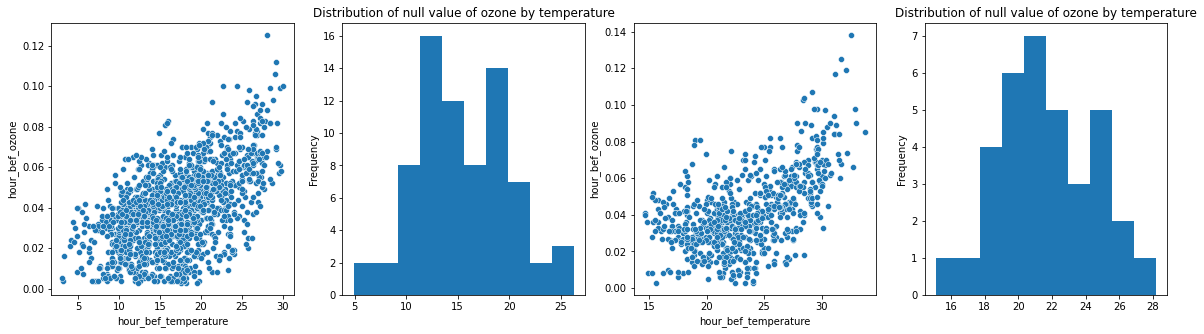

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(141)
sns.scatterplot(data = train, x = 'hour_bef_temperature', y = 'hour_bef_ozone')
plt.subplot(142)
train.loc[train['hour_bef_ozone'].isnull() == True, 'hour_bef_temperature'].plot(kind = 'hist')
plt.title('Distribution of null value of ozone by temperature', fontsize = 12)
plt.subplot(143)
sns.scatterplot(data = test, x = 'hour_bef_temperature', y = 'hour_bef_ozone')
plt.subplot(144)
test.loc[test['hour_bef_ozone'].isnull() == True, 'hour_bef_temperature'].plot(kind = 'hist')
plt.title('Distribution of null value of ozone by temperature', fontsize = 12)

In [22]:
ggg1 = train.loc[(0 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 10) == True, 'hour_bef_ozone']
ggg2 = train.loc[(10 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 20) == True, 'hour_bef_ozone']
ggg3 = train.loc[(20 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 30) == True, 'hour_bef_ozone']

gggt3 = test.loc[(10 < test['hour_bef_temperature']) & (test['hour_bef_temperature'] <= 20) == True, 'hour_bef_ozone']
gggt4 = test.loc[(20 < test['hour_bef_temperature']) & (test['hour_bef_temperature'] <= 30) == True, 'hour_bef_ozone']

In [23]:
ggg1.mean(), ggg2.mean(), ggg3.mean()

(0.02326612903225805, 0.035135105204872626, 0.054862359550561825)

In [24]:
gggt3.mean(), gggt4.mean()

(0.03298675496688742, 0.04099595959595958)

In [25]:
ccc1 = (train['hour_bef_ozone'].isnull() == True) & ((0 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 10) == True)
ccc2 = (train['hour_bef_ozone'].isnull() == True) & ((10 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 20) == True)
ccc3 = (train['hour_bef_ozone'].isnull() == True) & ((20 < train['hour_bef_temperature']) & (train['hour_bef_temperature'] <= 30) == True)

ccct3 = (test['hour_bef_ozone'].isnull() == True) & ((10 < test['hour_bef_temperature']) & (test['hour_bef_temperature'] <= 20) == True)
ccct4 = (test['hour_bef_ozone'].isnull() == True) & ((20 < test['hour_bef_temperature']) & (test['hour_bef_temperature'] <= 30) == True)

In [26]:
train.loc[ccc1, 'hour_bef_ozone'] = ggg1.mean()
train.loc[ccc2, 'hour_bef_ozone'] = ggg2.mean()
train.loc[ccc3, 'hour_bef_ozone'] = ggg3.mean()

test.loc[ccct3, 'hour_bef_ozone'] = gggt3.mean()
test.loc[ccct4, 'hour_bef_ozone'] = gggt4.mean()

4. 'hour_bef_wind_speed'

Text(0.5, 1.0, 'Distribution of null value of windspeed by ozone')

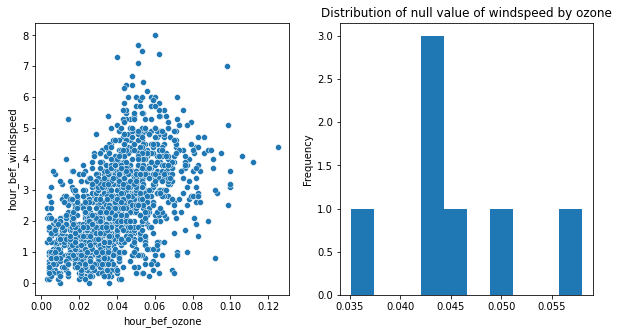

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.scatterplot(data = train, x = 'hour_bef_ozone', y = 'hour_bef_windspeed')
plt.subplot(122)
train.loc[train['hour_bef_windspeed'].isnull() == True, 'hour_bef_ozone'].plot(kind = 'hist')
plt.title('Distribution of null value of windspeed by ozone', fontsize = 12)

In [28]:
gggg1 = train.loc[(0.02 < train['hour_bef_ozone']) & (train['hour_bef_ozone'] <= 0.04) == True, 'hour_bef_windspeed']
gggg2 = train.loc[(0.04 < train['hour_bef_ozone']) & (train['hour_bef_ozone'] <= 0.06) == True, 'hour_bef_windspeed']

In [29]:
gggg1.mean(), gggg2.mean()

(2.028571428571428, 3.180717488789237)

In [30]:
cccc1 = (train['hour_bef_windspeed'].isnull() == True) & ((0.02 < train['hour_bef_ozone']) & (train['hour_bef_ozone'] <= 0.04) == True)
cccc2 = (train['hour_bef_windspeed'].isnull() == True) & ((0.04 < train['hour_bef_ozone']) & (train['hour_bef_ozone'] <= 0.06) == True)

In [31]:
train.loc[cccc1, 'hour_bef_windspeed'] = gggg1.mean()
train.loc[cccc2, 'hour_bef_windspeed'] = gggg2.mean()

In [32]:
np.sum(pd.isnull(train)), np.sum(pd.isnull(test))

(id                        0
 hour                      0
 hour_bef_temperature      0
 hour_bef_precipitation    0
 hour_bef_windspeed        0
 hour_bef_humidity         0
 hour_bef_visibility       0
 hour_bef_ozone            0
 hour_bef_pm10             0
 hour_bef_pm2.5            0
 count                     0
 dtype: int64, id                        0
 hour                      0
 hour_bef_temperature      0
 hour_bef_precipitation    0
 hour_bef_windspeed        0
 hour_bef_humidity         0
 hour_bef_visibility       0
 hour_bef_ozone            0
 hour_bef_pm10             0
 hour_bef_pm2.5            0
 dtype: int64)

# 이상치 처리

In [33]:
def outliers(df,n,columns):
    outlier_indices = []
    for col in columns:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = (Q3 - Q1)*1.5
        lowest = Q1 - IQR
        highest = Q3 + IQR
        
        outlier_index = df[col][(df[col] < lowest)|(df[col]>highest)].index
        outlier_indices.extend(outlier_index)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers  

In [34]:
outliers_to_drop = outliers(train,0,[ 'hour_bef_temperature', 
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm2.5'])
train = train.drop(outliers_to_drop,axis=0).reset_index(drop=True)
train.shape

(1375, 11)

# 모델링


In [ ]:
train.corr()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,1.000000,-0.010841,-0.002216,-0.054506,0.004619,-0.014634,0.010397,0.056500,-0.027070,0.004715,-0.010662
hour,-0.010841,1.000000,0.401493,0.021522,0.466900,-0.326529,0.186437,0.382266,-0.045381,-0.067656,0.627755
hour_bef_temperature,-0.002216,0.401493,1.000000,-0.097738,0.378898,-0.490701,0.217674,0.518951,-0.019879,-0.108567,0.610100
hour_bef_precipitation,-0.054506,0.021522,-0.097738,1.000000,0.012598,0.275061,-0.219259,-0.063439,-0.038760,0.029974,-0.163189
hour_bef_windspeed,0.004619,0.466900,0.378898,0.012598,1.000000,-0.441103,0.268153,0.523781,-0.011229,-0.201140,0.482227
hour_bef_humidity,-0.014634,-0.326529,-0.490701,0.275061,-0.441103,1.000000,-0.603164,-0.415901,-0.085357,0.200127,-0.466603
hour_bef_visibility,0.010397,0.186437,0.217674,-0.219259,0.268153,-0.603164,1.000000,0.132937,-0.411640,-0.661865,0.321855
hour_bef_ozone,0.056500,0.382266,0.518951,-0.063439,0.523781,-0.415901,0.132937,1.000000,0.089367,-0.026983,0.460674
hour_bef_pm10,-0.027070,-0.045381,-0.019879,-0.038760,-0.011229,-0.085357,-0.411640,0.089367,1.000000,0.484332,-0.129585
hour_bef_pm2.5,0.004715,-0.067656,-0.108567,0.029974,-0.201140,0.200127,-0.661865,-0.026983,0.484332,1.000000,-0.162371


In [35]:
train['hour_bef_visibility2'] = np.log(np.array(train['hour_bef_visibility'])).reshape(-1,1)
test['hour_bef_visibility2'] = np.log(np.array(test['hour_bef_visibility'])).reshape(-1,1)

In [36]:
train['hour_bef_pm10_2'] = (np.array(train['hour_bef_pm10'])-np.array(train['hour_bef_pm2.5'])).reshape(-1,1)
test['hour_bef_pm10_2'] = (np.array(test['hour_bef_pm10'])-np.array(test['hour_bef_pm2.5'])).reshape(-1,1)

In [37]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split ,cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [38]:
X_train= train[['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity','hour_bef_visibility2',
       'hour_bef_ozone','hour_bef_pm10_2', 'hour_bef_pm2.5']]
final_test= test[['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity' ,'hour_bef_visibility2',
       'hour_bef_ozone','hour_bef_pm10_2', 'hour_bef_pm2.5']]
y_train = train['count']

In [39]:
scaler = StandardScaler()

In [40]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.2, random_state = 2021)

In [41]:
x_train_ = scaler.fit_transform(x_train[['hour', 'hour_bef_temperature',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility2',
       'hour_bef_ozone','hour_bef_pm10_2', 'hour_bef_pm2.5']])
ar = np.array(x_train['hour_bef_precipitation'])
x_train_sc = np.c_[x_train_, ar]

x_val_ = scaler.transform(x_val[['hour', 'hour_bef_temperature',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility2',
       'hour_bef_ozone','hour_bef_pm10_2', 'hour_bef_pm2.5']])
ar2 = np.array(x_val['hour_bef_precipitation'])
x_val_sc = np.c_[x_val_,ar2]
x_train_sc.shape, x_val_sc.shape

((1100, 9), (275, 9))

In [75]:
x_train_ = scaler.fit_transform(train[['hour', 'hour_bef_temperature','hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility2',
       'hour_bef_ozone', 'hour_bef_pm10_2', 'hour_bef_pm2.5']])
ar = np.array(train['hour_bef_precipitation'])
x_train_sc = np.c_[train, ar]

y_train = train['count']

In [64]:
kfold = KFold(n_splits=5, random_state=2021)

In [ ]:
RFR = RandomForestRegressor(random_state = 2021)
params = {'n_estimators' : [1000],
          'max_depth' : [10,11],
          'min_samples_split' : [2,3],
          'min_samples_leaf' : [1,2]
          }
clf = GridSearchCV(RFR, param_grid=params ,cv = kfold, n_jobs=-1)
clf.fit(x_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=2021,
                                             ve

In [ ]:
clf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [ ]:
LGB = LGBMRegressor(random_state=2021)
params2 = {'n_estimators' : [1000,1200,1400,1600,1800,2000],
          'num_leaves' : [8,16,32,64,128,256,512],
          'learning_rate' : [0.001,0.01,0.1,0.5],
           'max_depth' : [3,6,9,12]
          }
clf2 = GridSearchCV(LGB, param_grid=params2 ,cv = kfold)
clf2.fit(x_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_sta...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'max_depth': [3, 6, 9, 12],
  

In [ ]:
clf2.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'num_leaves': 8}

In [ ]:
GBR = GradientBoostingRegressor(random_state = 2021)
params3 = {'n_estimators' : [200,400,600,800,1000],
          'learning_rate' : [0.001,0.005,0.01,0.05,0.1],
           'max_depth':[3,5,7,9],
            
          }
clf3 = GridSearchCV(GBR, param_grid=params3 ,cv = kfold, n_jobs = -1)
clf3.fit(x_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...
                                                 subsample=1.0, tol=0.0001,
                                     

In [ ]:
clf3.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [77]:
ETR = ExtraTreesRegressor(random_state = 2021)
params = {'n_estimators' : [1400,1800],
          'max_depth' : [11,14],
          }
clf5 = GridSearchCV(ETR, param_grid=params ,cv = kfold, n_jobs=-1)
clf5.fit(x_train_sc, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
             error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=2021,
                                           verbose=0, warm_start=False

In [78]:
clf5.best_params_

{'max_depth': 14, 'n_estimators': 1800}

In [ ]:
XGB = XGBRegressor(random_state=2021)
params = {'learning_rate': [0.01],
             'n_estimators': [2000]
             ,'max_depth': [9]
          }
clf6 = GridSearchCV(XGB, param_grid = params, cv = kfold,n_jobs = -1 )
clf6.fit(x_train_sc, y_train)

[12:03:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    object...r', random_state=2021,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [9],
           

In [ ]:
clf6.best_params_

{'learning_rate': 0.01,
 'max_depth': 9,
 'min_child_weight': 1,
 'n_estimators': 2000}

In [42]:
RandomForest_clf = RandomForestRegressor(n_estimators =  1000, max_depth = 10, min_samples_split =  3,random_state = 2021)
LGB_clf = LGBMRegressor(learning_rate = 0.01, n_estimators = 1000, num_leaves = 8,max_depth = 3,random_state=2021)
Gradient_clf = GradientBoostingRegressor(learning_rate =  0.01, n_estimators =  1000, max_depth = 3,random_state = 2021)
ExtraTree_clf = ExtraTreesRegressor(max_depth =  14 ,n_estimators =  1800, random_state = 2021)
XGBoost_clf = XGBRegressor(learning_rate =  0.01, n_estimators =  2000,max_depth = 9,random_state = 2021)

In [43]:
estimators = [RandomForest_clf, LGB_clf, Gradient_clf, ExtraTree_clf, XGBoost_clf]
for estimator in estimators :
  estimator.fit(x_train_sc, y_train)

[11:41:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
for estimator in estimators :
  y_pred = estimator.predict(x_val_sc)
  mse = mean_squared_error(y_pred, y_val)
  rmse = np.sqrt(mse)
  print(rmse)

36.34154209734633
36.75993597408493
36.8457160269155
34.07995037705517
35.966223476032326


In [55]:
Estimators_voting = [
    #("RandomForest_clf", RandomForest_clf),
    ("LGB_clf", LGB_clf),
    ("Gradient_clf", Gradient_clf),
    ("ExtraTree_clf", ExtraTree_clf),
    #("XGBoost_clf", XGBoost_clf),
]

In [56]:
Voting_clf = VotingRegressor(Estimators_voting)
Voting_clf.fit(x_train_sc, y_train)

VotingRegressor(estimators=[('LGB_clf',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.01, max_depth=3,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0,
                                           n_estimators=1000, n_jobs=-1,
                                           num_leaves=8, objective=None,
                                           random_state=2021, reg_alpha=0.0,
                                           reg_lambda=0.0, silent=True,
                                           subs...
                             ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
  

In [57]:
Estimators_voting2 = [
    ("RandomForest_clf", RandomForest_clf),
    ("ExtraTree_clf", ExtraTree_clf),
    ("XGBoost_clf", XGBoost_clf)
    ]
  
Voting_clf2 = VotingRegressor(Estimators_voting2)
Voting_clf2.fit(x_train_sc, y_train)

[11:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('RandomForest_clf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=10,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=3,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=1000,
                        

In [65]:
Estimators_voting3 = [
    ("Voting_clf", Voting_clf),
    ("Voting_clf2", Voting_clf2),
    ]
  
a = StackingRegressor(Estimators_voting3, cv = kfold, n_jobs=-1)
a.fit(x_train_sc, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
                  estimators=[('Voting_clf',
                               VotingRegressor(estimators=[('LGB_clf',
                                                            LGBMRegressor(boosting_type='gbdt',
                                                                          class_weight=None,
                                                                          colsample_bytree=1.0,
                                                                          importance_type='split',
                                                                          learning_rate=0.01,
                                                                          max_depth=3,
                                                                          min_child_samples=20,
                                                                          min_child_weight=0.001,
                                                   

In [60]:
y_pred = Voting_clf.predict(x_val_sc)
mse = mean_squared_error(y_pred, y_val)
rmse = np.sqrt(mse)
print(rmse)

35.32626054929902


In [61]:
y_pred = Voting_clf2.predict(x_val_sc)
mse = mean_squared_error(y_pred, y_val)
rmse = np.sqrt(mse)
print(rmse)

34.72557938232562


In [66]:
y_pred = a.predict(x_val_sc)
mse = mean_squared_error(y_pred, y_val)
rmse = np.sqrt(mse)
print(rmse)

34.44388249601956


# 최종 예측

In [172]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train[['hour', 'hour_bef_temperature','hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility2',
       'hour_bef_ozone', 'hour_bef_pm10_2', 'hour_bef_pm2.5']])
ar = np.array(X_train['hour_bef_precipitation'])
X_train_sc = np.c_[X_train_, ar]

x_test_ = scaler.transform(final_test[['hour', 'hour_bef_temperature','hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility2',
       'hour_bef_ozone', 'hour_bef_pm10_2', 'hour_bef_pm2.5']])
ar2 = np.array(final_test['hour_bef_precipitation'])
X_test_sc = np.c_[x_test_,ar2]

In [173]:
RandomForest_final = RandomForestRegressor(n_estimators =  1000, max_depth = 10, min_samples_split =  3,random_state = 2021)
LGB_final = LGBMRegressor(learning_rate = 0.01, n_estimators = 1000, num_leaves = 8,max_depth = 3,random_state=2021)
Gradient_final = GradientBoostingRegressor(learning_rate =  0.01, n_estimators =  1000, max_depth = 3,random_state = 2021)
ExtraTree_final = ExtraTreesRegressor(max_depth =  14, n_estimators =  1800,random_state = 2021)
XGBoost_final = XGBRegressor(learning_rate =  0.01, n_estimators =  2000, max_depth = 9,random_state = 2021)

In [174]:
estimators_final = [RandomForest_final, LGB_final, Gradient_final ,ExtraTree_final, XGBoost_final]
for estimator in estimators_final :
  estimator.fit(X_train_sc, train['count'])

[11:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [179]:
Estimators_final = [
    #('RandomForest_final',RandomForest_final),
    ("LGB_final", LGB_final),
    ("Gradient_final", Gradient_final),
    ("ExtraTree_final", ExtraTree_final),
    
]

In [180]:
Voting_final = VotingRegressor(Estimators_final)
Voting_final.fit(X_train_sc, train['count'])

Estimators_final2 = [
    ("Voting_final", Voting_final),
    ("ExtraTree_final", ExtraTree_final),
    ("XGBoost_final", XGBoost_final),
]

Voting_final2 = VotingRegressor(Estimators_final2)
Voting_final2.fit(X_train_sc, train['count'])

[11:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('Voting_final',
                             VotingRegressor(estimators=[('LGB_final',
                                                          LGBMRegressor(boosting_type='gbdt',
                                                                        class_weight=None,
                                                                        colsample_bytree=1.0,
                                                                        importance_type='split',
                                                                        learning_rate=0.01,
                                                                        max_depth=3,
                                                                        min_child_samples=20,
                                                                        min_child_weight=0.001,
                                                                        min_split_gain=0.0,
                                                 

In [181]:
predictions = Voting_final2.predict(X_test_sc)
predictions

array([102.40484961, 216.0741427 ,  56.25139706,  40.42876268,
        62.94701382, 124.16215054, 205.13976966, 312.33490793,
        45.03645621, 129.38435266, 281.19204731, 238.36082873,
       104.23877904,  48.61096716, 186.43972416, 139.09316284,
        26.32522503, 154.16319421, 334.44967794, 152.74937177,
       209.14459975,  94.56348399,  30.9482411 , 127.12366359,
       129.29174078, 105.65232046,  27.96756688, 113.37603781,
       107.21131406, 156.48678782,  68.57359444,  41.29393844,
        80.08975756, 125.20179219, 271.45133728,  44.38309897,
       129.70508636,  92.01098009, 178.45401834,  84.30086678,
        47.93779346, 120.44419917, 185.81914958,  75.89030095,
       319.15641421, 194.84285788,  83.46564882,  72.87654519,
        25.65346195,  86.49617843, 232.66000039,  98.05986924,
       132.51595559,  82.76432947, 165.55019019, 113.61643813,
        50.57291423, 168.47674013,  28.51645603,  20.83856994,
        92.37965758,  89.34240604, 261.3001532 , 288.87

In [183]:
submission['count'] = predictions
submission.to_csv(file3, index = False)

In [ ]:
function ClickConnect(){
    console.log("1분마다 코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 1000 * 60);

In [ ]:
#Stack_final = StackingRegressor(
#     estimators=Estimators_final,cv = kfold, n_jobs = -1)
#Stack_final.fit(x_train_sc, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=2021, shuffle=False),
                  estimators=[('LGB_final',
                               LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.01, max_depth=3,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=1000, n_jobs=-1,
                                             num_leaves=8, objective=None,
                                             random...
                                            colsample_bytree=1, gamma=0,
                                            importance_ty